<a href="https://colab.research.google.com/github/SaniRadanlieva/SeminarskaRabota/blob/master/SeminarskaRabota_203120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Стандардна семинарска работа по предметот Вовед во науката за податоци


 Тема: Да се најдат податоците за цената на акциите и ESG score на компанијата Nike за изминатите 4 години. Потоа, да се проучат податоците со користење на tsfresh и истите да се објаснат. Да се направи benchmark на најмалку 3 модели за предикција на цена на акциите на компанијата имајќи ги предвид горенаведените податоци.

## Обработка на ESG score податоците со помош на tsfresh

Собирање на податоци за ESG score на компанијата Nike



In [ ]:
!pip install yesg
!pip install yfinance
!pip install tsfresh

In [65]:
import yfinance
import yesg
from tsfresh import extract_features
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as pg
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [3]:
esg = yesg.get_historic_esg('NKE')
esg.head()

,Total-Score,E-Score,S-Score,G-Score
Date,,,,
2014-09-01,73.0,69.0,75.0,75.0
2014-10-01,73.0,69.0,75.0,75.0
2014-11-01,73.0,69.0,75.0,75.0
2014-12-01,73.0,69.0,75.0,75.0
2015-01-01,73.0,69.0,75.0,75.0


Индексната колона Date ја правам дел од податочното множество, се справувам со null вредности и правам приказ на дел од визуелизациите за достапните податоци.
Исто така, ги издвојувам податоците за последните 4 години.

In [4]:
esg = esg.reset_index()

In [5]:
esg['Date'] = pd.to_datetime(esg['Date'])
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime(pd.Timestamp.now().date())
esg = esg[(esg['Date'] >= start_date) & (esg['Date'] <= end_date)]

Справување со null вредности со метод bfill, пополнуваме вредност со следните вредности

In [6]:
esg_filled = esg.fillna(method ='bfill')

In [7]:
null_count = esg.isnull().sum().sum()
print('Број на null/NaN вредности во податочното множество за ESG score:', null_count)

Број на null/NaN вредности во податочното множество за ESG score: 72


In [12]:
esg_filled.head()

,Date,Total_Score,E_Score,S_Score,G_Score
63,2019-12-01,17.07,2.05,6.34,8.68
64,2020-01-01,17.07,2.05,6.34,8.68
65,2020-02-01,16.52,2.05,6.34,8.12
66,2020-03-01,16.52,2.05,6.34,8.12
67,2020-04-01,16.78,2.05,6.96,7.77


In [13]:
start_date = pd.to_datetime('2019-12-01')
end_date = pd.to_datetime(pd.Timestamp.now().date())
esg_filled = esg_filled[(esg_filled['Date'] >= start_date) & (esg_filled['Date'] <= end_date)]
esg_filled

,Date,Total_Score,E_Score,S_Score,G_Score
63,2019-12-01,17.07,2.05,6.34,8.68
64,2020-01-01,17.07,2.05,6.34,8.68
65,2020-02-01,16.52,2.05,6.34,8.12
66,2020-03-01,16.52,2.05,6.34,8.12
67,2020-04-01,16.78,2.05,6.96,7.77
68,2020-05-01,16.78,2.05,6.96,7.77
69,2020-06-01,16.78,2.05,6.96,7.77
70,2020-07-01,16.78,2.05,6.96,7.77
71,2020-08-01,16.09,2.05,6.56,7.48
72,2020-09-01,16.12,2.05,6.56,7.51


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(esg_filled, *['Total_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(esg_filled, *['E_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(esg_filled, *['S_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(esg_filled, *['G_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(esg_filled, *['Total_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(esg_filled, *['E_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(esg_filled, *['S_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(esg_filled, *['G_Score'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(esg_filled, *[[['Total_Score', 'E_Score'], ['E_Score', 'S_Score'], ['S_Score', 'G_Score']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(esg_filled, *['Date', 'Total_Score', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(esg_filled, *['Date', 'S_Score', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(esg_filled, *['Date', 'G_Score', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(esg_filled, *['Date', 'count()', None], **{})
chart

Користење на tsfresh за анализа на ESG резултатите на Nike

In [14]:
esg_filled.rename(columns={'Total-Score': 'Total_Score'}, inplace=True)
esg_filled.rename(columns={'E-Score': 'E_Score'}, inplace=True)
esg_filled.rename(columns={'S-Score': 'S_Score'}, inplace=True)
esg_filled.rename(columns={'G-Score': 'G_Score'}, inplace=True)

In [15]:
extracted_total = extract_features(esg_filled, column_id='Total_Score', column_sort='Date')
print(extracted_total)

Feature Extraction: 100%|██████████| 30/30 [00:01<00:00, 25.00it/s]


       E_Score__variance_larger_than_standard_deviation  \
14.80                                               0.0   
15.34                                               0.0   
15.38                                               0.0   
16.09                                               0.0   
16.12                                               0.0   
16.52                                               0.0   
16.78                                               0.0   
16.80                                               0.0   
16.95                                               0.0   
17.07                                               0.0   

       E_Score__has_duplicate_max  E_Score__has_duplicate_min  \
14.80                         1.0                         1.0   
15.34                         1.0                         1.0   
15.38                         1.0                         1.0   
16.09                         0.0                         0.0   
16.12                    

In [16]:
extracted_escore = extract_features(esg_filled, column_id='E_Score', column_sort='Date')
print(extracted_escore)

Feature Extraction: 100%|██████████| 15/15 [00:00<00:00, 22.14it/s]


      Total_Score__variance_larger_than_standard_deviation  \
2.05                                                0.0      
2.29                                                0.0      
2.48                                                0.0      
2.71                                                0.0      
3.04                                                0.0      

      Total_Score__has_duplicate_max  Total_Score__has_duplicate_min  \
2.05                             1.0                             0.0   
2.29                             1.0                             1.0   
2.48                             1.0                             1.0   
2.71                             1.0                             1.0   
3.04                             1.0                             1.0   

      Total_Score__has_duplicate  Total_Score__sum_values  \
2.05                         1.0                   182.63   
2.29                         1.0                   104.68   
2.48       

In [21]:
extracted_sscore = extract_features(esg_filled, column_id='S_Score', column_sort='Date')
print(extracted_sscore)

Feature Extraction: 100%|██████████| 21/21 [00:00<00:00, 21.48it/s]


      Total_Score__variance_larger_than_standard_deviation  \
5.56                                                0.0      
5.61                                                0.0      
5.77                                                0.0      
6.34                                                0.0      
6.56                                                0.0      
6.96                                                0.0      
6.99                                                0.0      

      Total_Score__has_duplicate_max  Total_Score__has_duplicate_min  \
5.56                             1.0                             1.0   
5.61                             1.0                             1.0   
5.77                             1.0                             1.0   
6.34                             1.0                             1.0   
6.56                             1.0                             0.0   
6.96                             1.0                             1.0   

In [22]:
extracted_gscore = extract_features(esg_filled, column_id='G_Score', column_sort='Date')
print(extracted_gscore)

Feature Extraction: 100%|██████████| 27/27 [00:01<00:00, 25.16it/s]


      Total_Score__variance_larger_than_standard_deviation  \
6.92                                                0.0      
6.95                                                0.0      
7.10                                                0.0      
7.28                                                0.0      
7.48                                                0.0      
7.51                                                0.0      
7.77                                                0.0      
8.12                                                0.0      
8.68                                                0.0      

      Total_Score__has_duplicate_max  Total_Score__has_duplicate_min  \
6.92                             1.0                             1.0   
6.95                             1.0                             1.0   
7.10                             1.0                             1.0   
7.28                             1.0                             1.0   
7.48               

## Обработка на цените на акции на Nike со помош на tsfresh

Собирање на податоци за цените на акциите на компанијата Nike

In [ ]:
symbol = "NKE"
stock = yfinance.download(symbol, start="2019-01-01", end=None)
stocks2 = yfinance.download(symbol, start="2019-01-01", end=None)
stocks3 =  yfinance.download(symbol, start="2019-01-01", end=None)

Индексната колона Date ја правам дел од податочното множество и правам приказ на дел од визуелизациите за достапните податоци.

In [153]:
stock = stock.reset_index()
stocks2 = stocks2.reset_index()
stocks3 = stocks3.reset_index()

In [27]:
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,72.790001,74.639999,72.190002,74.059998,70.848503,6762700
1,2019-01-03,73.250000,73.320000,71.209999,72.750000,69.595345,8007400
2,2019-01-04,73.449997,75.120003,73.120003,74.650002,71.412956,7844200
3,2019-01-07,74.739998,76.360001,74.300003,75.720001,72.436546,8184800
4,2019-01-08,76.830002,77.400002,76.199997,76.730003,73.402756,8809000
...,...,...,...,...,...,...,...
1170,2023-08-25,98.500000,99.089996,97.809998,98.839996,98.839996,7289600
1171,2023-08-28,99.589996,100.059998,98.870003,99.629997,99.629997,6006600
1172,2023-08-29,100.029999,102.160004,99.720001,101.769997,101.769997,8641600
1173,2023-08-30,101.639999,102.809998,101.510002,102.099998,102.099998,4822100


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(stock, *['Open'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(stock, *['High'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(stock, *['Low'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(stock, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(stock, *['Open'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(stock, *['High'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(stock, *['Low'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(stock, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(stock, *[[['Open', 'High'], ['High', 'Low'], ['Low', 'Close'], ['Close', 'Adj Close']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(stock, *['Date', 'Open', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(stock, *['Date', 'High', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(stock, *['Date', 'Low', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(stock, *['Date', 'Close', None], **{})
chart

In [28]:
null_count = stock.isnull().sum().sum()
print('Број на null/NaN вредности во податочното множество за цените на акции', null_count)

Број на null/NaN вредности во податочното множество за цените на акции 0


Користење на tsfresh за анализа на цените на акции на Nike

In [29]:
extracted_open = extract_features(stock, column_id='Open', column_sort='Date')
print(extracted_open)

Feature Extraction: 100%|██████████| 5305/5305 [03:14<00:00, 27.33it/s]


            High__variance_larger_than_standard_deviation  \
64.790001                                             0.0   
65.000000                                             0.0   
65.279999                                             0.0   
65.699997                                             0.0   
67.040001                                             0.0   
...                                                   ...   
173.050003                                            0.0   
174.360001                                            0.0   
174.979996                                            0.0   
175.729996                                            0.0   
176.350006                                            0.0   

            High__has_duplicate_max  High__has_duplicate_min  \
64.790001                       0.0                      0.0   
65.000000                       0.0                      0.0   
65.279999                       0.0                      0.0   
65.699997  

In [30]:
extracted_high = extract_features(stock, column_id='High', column_sort='Date')
print(extracted_high)

Feature Extraction: 100%|██████████| 5480/5480 [03:17<00:00, 27.73it/s]


            Open__variance_larger_than_standard_deviation  \
66.879997                                             0.0   
68.330002                                             0.0   
72.660004                                             0.0   
72.709999                                             0.0   
72.970001                                             0.0   
...                                                   ...   
175.630005                                            0.0   
176.539993                                            0.0   
177.199997                                            0.0   
177.750000                                            0.0   
179.100006                                            0.0   

            Open__has_duplicate_max  Open__has_duplicate_min  \
66.879997                       0.0                      0.0   
68.330002                       0.0                      0.0   
72.660004                       0.0                      0.0   
72.709999  

In [31]:
extracted_low = extract_features(stock, column_id='Low', column_sort='Date')
print(extracted_low)

Feature Extraction: 100%|██████████| 5420/5420 [03:27<00:00, 26.12it/s]


            Open__variance_larger_than_standard_deviation  \
60.000000                                             0.0   
60.580002                                             0.0   
62.400002                                             0.0   
63.369999                                             0.0   
64.000000                                             0.0   
...                                                   ...   
171.619995                                            0.0   
172.000000                                            0.0   
172.699997                                            0.0   
174.229996                                            0.0   
175.500000                                            0.0   

            Open__has_duplicate_max  Open__has_duplicate_min  \
60.000000                       0.0                      0.0   
60.580002                       0.0                      0.0   
62.400002                       0.0                      0.0   
63.369999  

In [32]:
extracted_close = extract_features(stock, column_id='Close', column_sort='Date')
print(extracted_close)

Feature Extraction: 100%|██████████| 5455/5455 [03:25<00:00, 26.50it/s]


            Open__variance_larger_than_standard_deviation  \
62.799999                                             0.0   
66.790001                                             0.0   
67.449997                                             0.0   
68.040001                                             0.0   
69.839996                                             0.0   
...                                                   ...   
173.850006                                            0.0   
174.240005                                            0.0   
174.880005                                            0.0   
175.440002                                            0.0   
177.509995                                            0.0   

            Open__has_duplicate_max  Open__has_duplicate_min  \
62.799999                       0.0                      0.0   
66.790001                       0.0                      0.0   
67.449997                       0.0                      0.0   
68.040001  

In [33]:
extracted_adjClose = extract_features(stock, column_id='Adj Close', column_sort='Date')
print(extracted_adjClose)

Feature Extraction: 100%|██████████| 5760/5760 [03:31<00:00, 27.25it/s]


            Open__variance_larger_than_standard_deviation  \
60.881489                                             0.0   
64.749596                                             0.0   
65.389427                                             0.0   
65.961403                                             0.0   
67.706421                                             0.0   
...                                                   ...   
170.614120                                            0.0   
171.026352                                            0.0   
171.654556                                            0.0   
172.204239                                            0.0   
174.236023                                            0.0   

            Open__has_duplicate_max  Open__has_duplicate_min  \
60.881489                       0.0                      0.0   
64.749596                       0.0                      0.0   
65.389427                       0.0                      0.0   
65.961403  

In [34]:
extracted_volume = extract_features(stock, column_id='Volume', column_sort='Date')
print(extracted_volume)

Feature Extraction: 100%|██████████| 5815/5815 [03:36<00:00, 26.89it/s]


          Open__variance_larger_than_standard_deviation  \
1821900                                             0.0   
2541800                                             0.0   
2658600                                             0.0   
2666800                                             0.0   
2752000                                             0.0   
...                                                 ...   
31296500                                            0.0   
32777300                                            0.0   
37822700                                            0.0   
46285400                                            0.0   
48176100                                            0.0   

          Open__has_duplicate_max  Open__has_duplicate_min  \
1821900                       0.0                      0.0   
2541800                       0.0                      0.0   
2658600                       0.0                      0.0   
2666800                       0.0          

## Модели за предикција на цените на акции на Nike

### Модел за предикција на цените на акции на Nike: **Random Forest Classifier**

<Axes: xlabel='Date'>

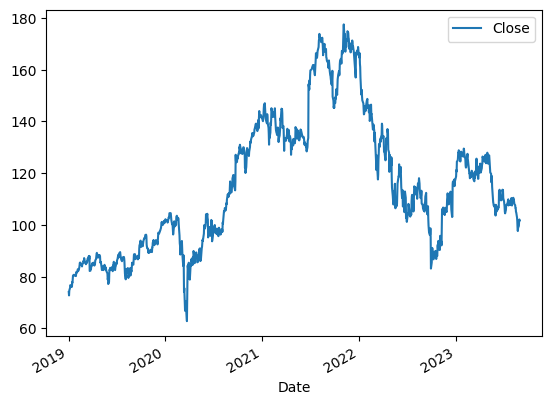

In [35]:
stock.plot.line(x='Date', y='Close')

In [36]:
stock['Tomorrow'] = stock['Close'].shift(-1)
stock

,Date,Open,High,Low,Close,Adj Close,Volume,Tomorrow
0,2019-01-02,72.790001,74.639999,72.190002,74.059998,70.848503,6762700,72.750000
1,2019-01-03,73.250000,73.320000,71.209999,72.750000,69.595345,8007400,74.650002
2,2019-01-04,73.449997,75.120003,73.120003,74.650002,71.412956,7844200,75.720001
3,2019-01-07,74.739998,76.360001,74.300003,75.720001,72.436546,8184800,76.730003
4,2019-01-08,76.830002,77.400002,76.199997,76.730003,73.402756,8809000,76.589996
...,...,...,...,...,...,...,...,...
1170,2023-08-25,98.500000,99.089996,97.809998,98.839996,98.839996,7289600,99.629997
1171,2023-08-28,99.589996,100.059998,98.870003,99.629997,99.629997,6006600,101.769997
1172,2023-08-29,100.029999,102.160004,99.720001,101.769997,101.769997,8641600,102.099998
1173,2023-08-30,101.639999,102.809998,101.510002,102.099998,102.099998,4822100,101.709999


In [37]:
stock['Target'] = (stock['Tomorrow'] > stock['Close']).astype(int)
stock

,Date,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
0,2019-01-02,72.790001,74.639999,72.190002,74.059998,70.848503,6762700,72.750000,0
1,2019-01-03,73.250000,73.320000,71.209999,72.750000,69.595345,8007400,74.650002,1
2,2019-01-04,73.449997,75.120003,73.120003,74.650002,71.412956,7844200,75.720001,1
3,2019-01-07,74.739998,76.360001,74.300003,75.720001,72.436546,8184800,76.730003,1
4,2019-01-08,76.830002,77.400002,76.199997,76.730003,73.402756,8809000,76.589996,0
...,...,...,...,...,...,...,...,...,...
1170,2023-08-25,98.500000,99.089996,97.809998,98.839996,98.839996,7289600,99.629997,1
1171,2023-08-28,99.589996,100.059998,98.870003,99.629997,99.629997,6006600,101.769997,1
1172,2023-08-29,100.029999,102.160004,99.720001,101.769997,101.769997,8641600,102.099998,1
1173,2023-08-30,101.639999,102.809998,101.510002,102.099998,102.099998,4822100,101.709999,0


In [38]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)

In [39]:
split_index = int(len(stock) * 0.8)
train = stock.iloc[:split_index]
test = stock.iloc[split_index:]

In [40]:
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=10, random_state=1)

In [41]:
preds = model.predict(test[predictors])
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [42]:
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [43]:
precision_score(test["Target"], preds)

0.49606299212598426

In [46]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [48]:
def backtest(data, model, predictors, start=300, step=30):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [49]:
predictions = backtest(stock, model, predictors)

In [50]:
predictions["Predictions"].value_counts()

1    529
0    346
Name: Predictions, dtype: int64

In [51]:
precision_score(predictions["Target"], predictions["Predictions"])

0.499054820415879

In [53]:
predictions

,Target,Predictions
300,1,1
301,0,1
302,1,1
303,0,1
304,1,1
...,...,...
1170,1,1
1171,1,1
1172,1,0
1173,0,0


In [60]:
from sklearn.metrics import classification_report
y_true = predictions["Target"]
y_pred = predictions["Predictions"]
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.40      0.44       439
           1       0.50      0.61      0.55       436

    accuracy                           0.50       875
   macro avg       0.50      0.50      0.50       875
weighted avg       0.50      0.50      0.50       875



In [64]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.501714
1    0.498286
Name: Target, dtype: float64

### Модел за предикција на цените на акции на Nike: **LSTM**

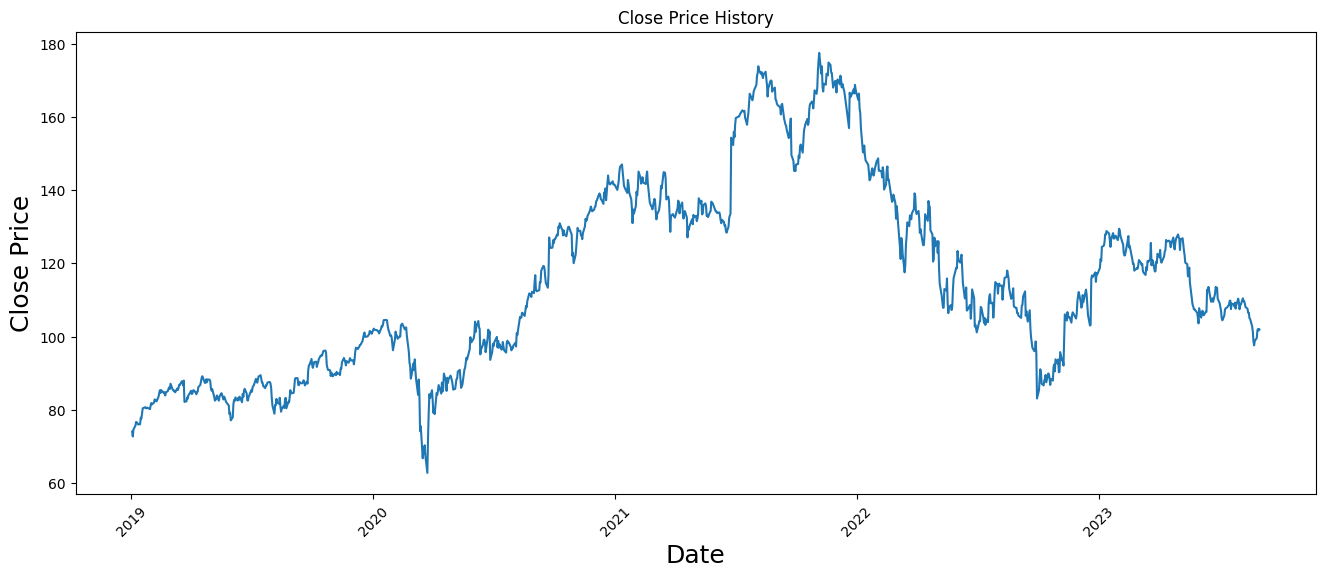

In [154]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(stocks2['Date'], stocks2['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [155]:
data = stocks2.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

1118

In [170]:
result = pd.concat([stocks2, data], axis=0)

In [156]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.09816057],
       [0.08674049],
       [0.10330401],
       ...,
       [0.34260309],
       [0.33920322],
       [0.34155702]])

In [157]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

In [158]:
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.09816057, 0.08674049, 0.10330401, 0.11263188, 0.12143671,
       0.12021618, 0.11873419, 0.11542152, 0.11585736, 0.13146194,
       0.12971844, 0.14235898, 0.15386626, 0.15648158, 0.15430217,
       0.15377913, 0.15526111, 0.15273299, 0.15186124, 0.16110191,
       0.16633248, 0.163107  , 0.16729143, 0.17487579, 0.17356813,
       0.17077849, 0.17051697, 0.18202425, 0.19100341, 0.1970186 ,
       0.19074189, 0.19684421, 0.18978294, 0.19213668, 0.18437798,
       0.19143931, 0.19501351, 0.20050566, 0.20373115, 0.19989543,
       0.21236165, 0.19911081, 0.19736731, 0.1946648 , 0.19579813,
       0.19178803, 0.20067999, 0.19728012, 0.20163893, 0.20983353,
       0.2092233 , 0.21811526, 0.21698199, 0.20826436, 0.21977163,
       0.16903499, 0.17025546, 0.17940893, 0.17688081, 0.18516261])]
[0.18664458835570508]

[array([0.09816057, 0.08674049, 0.10330401, 0.11263188, 0.12143671,
       0.12021618, 0.11873419, 0.11542152, 0.11585736, 0.13146194,
       0.12971844, 0.14235898, 0.15

In [159]:
x_train.shape

(1058, 60, 1)

In [160]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

1058/1058 [==============================] - 59s 51ms/step - loss: 0.0031


In [161]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 36ms/step


4.352552781040314

In [162]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-162-8f78faa8f9ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


<ipython-input-323-bc399a2ce523>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



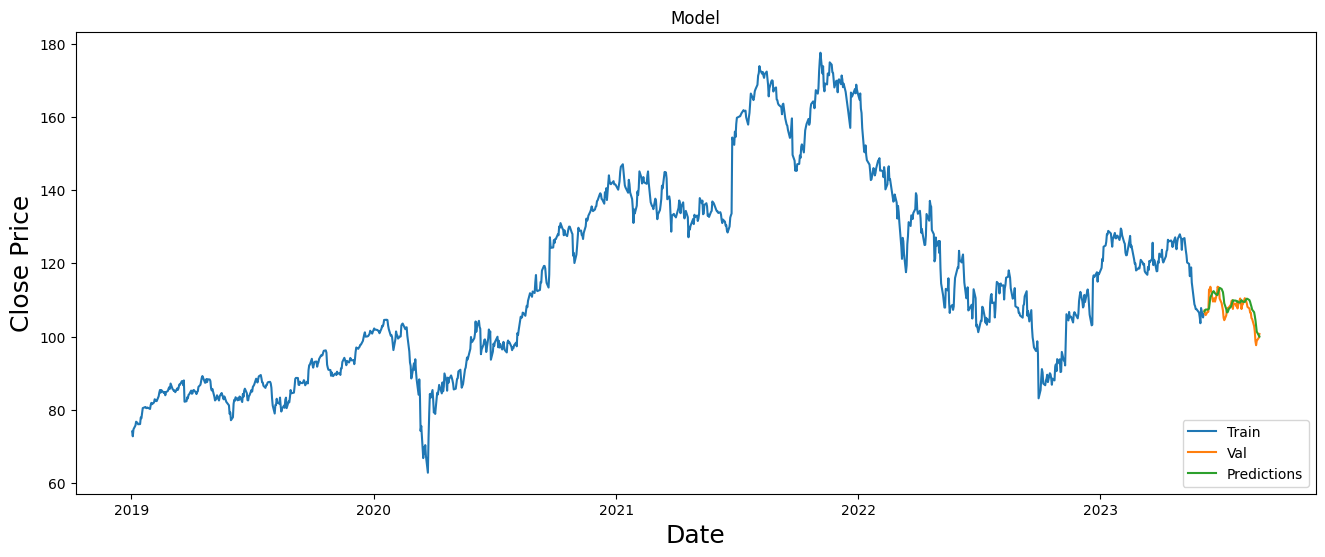

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,Close,Predictions
Date,,
2023-06-07,107.089996,106.816460
2023-06-08,106.199997,107.194717
2023-06-09,105.860001,107.372284
2023-06-12,106.830002,107.350784
2023-06-13,106.779999,107.473068
2023-06-14,112.860001,107.598907
2023-06-15,112.410004,109.108276
2023-06-16,113.589996,110.688042
2023-06-20,109.540001,112.216362


### Модел за предикција на цените на акции на Nike: **Facebook Prophet**

In [191]:
stocks3.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1.176000e+03
mean,115.290400,116.523299,114.023316,115.280408,112.901917,6.949327e+06
std,25.880365,26.011041,25.656930,25.801312,25.783285,3.811711e+06
min,64.790001,66.879997,60.000000,62.799999,60.881496,1.821900e+06
25%,92.792498,93.887499,92.042498,92.900002,89.846355,4.914500e+06
50%,110.380001,112.054996,109.215000,110.490002,109.572292,6.045250e+06
75%,133.559994,134.732502,132.149994,133.350006,130.475315,7.702775e+06
max,176.350006,179.100006,175.500000,177.509995,174.236053,4.817610e+07


In [192]:
stocks3 = stocks3[["Date","Close"]]
stocks3 = stocks3.rename(columns = {"Date":"ds","Close":"y"})
stocks3.head(5)

,ds,y
0,2019-01-02,74.059998
1,2019-01-03,72.750000
2,2019-01-04,74.650002
3,2019-01-07,75.720001
4,2019-01-08,76.730003


In [ ]:
!git clone https://github.com/facebook/prophet.git
!cd prophet/python && python setup.py install

In [ ]:
from prophet import Prophet
m = Prophet(daily_seasonality = True)
m.fit(stocks3)

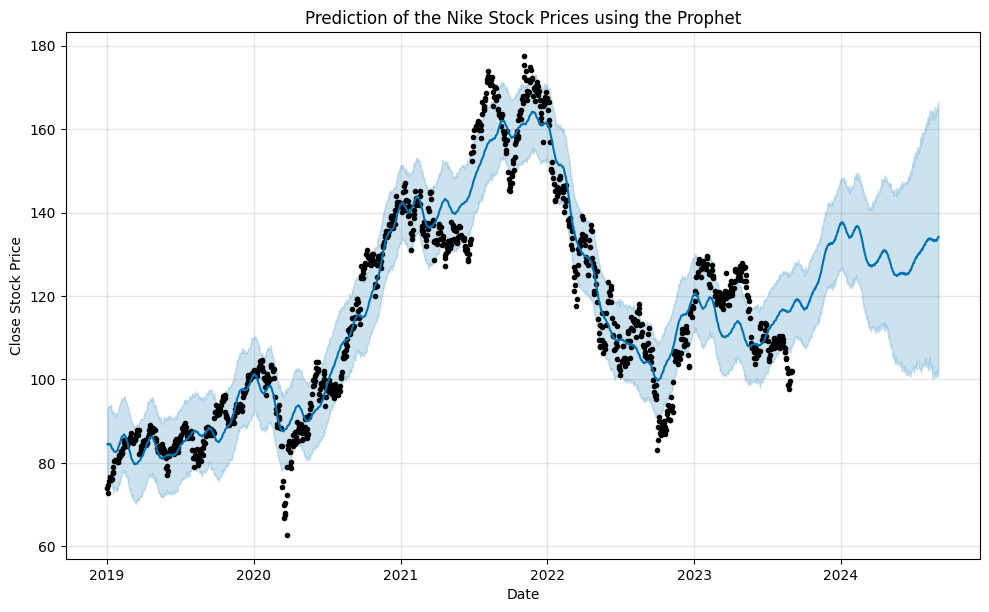

In [195]:
future = m.make_future_dataframe(periods=365)
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Nike Stock Prices using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

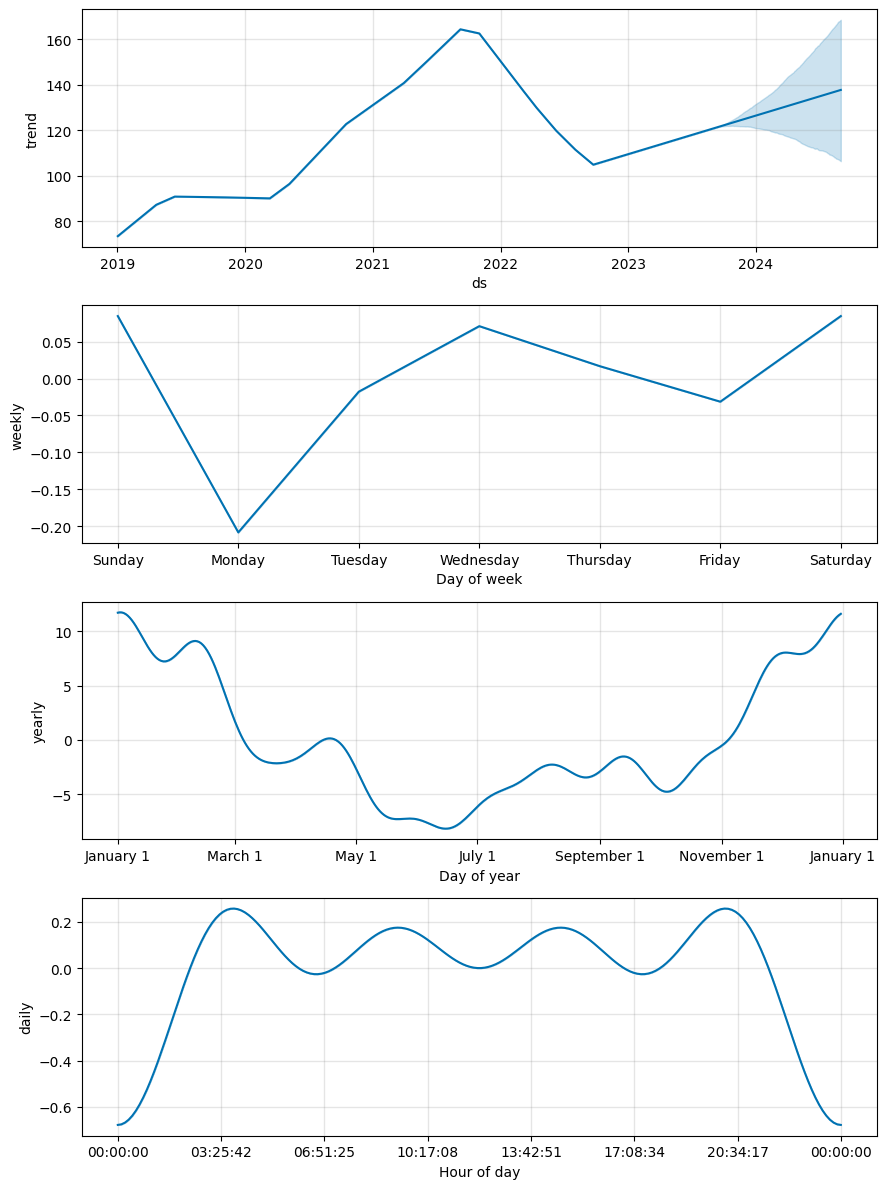

In [196]:
m.plot_components(prediction)
plt.show()